In [2]:
# %% [markdown]
"""
# Analysis of Parallel ACO Experiment Results

This notebook reads the aggregated CSV reports from our ParallelExperiment runs and produces line plots to analyze how the solution quality (best fitness) and runtime change when varying:
1. The number of ants (with fixed batch size)
2. The batch size (with fixed number of ants)

We also include a basic trade-off analysis plot for each experiment.
"""

# %% Import Libraries
import pandas as pd
import matplotlib.pyplot as plt

## Load Aggregated Results

We load the two aggregated CSV files:
- One for varying number of ants ("experiment_varying_ants_summary.csv")
- One for varying batch size ("experiment_varying_batch_size_summary.csv")


In [3]:
sen_small = pd.read_csv("data/sen.small.summary.csv")
sen_medium = pd.read_csv("data/sen.medium.summary.csv")
sen_large = pd.read_csv("data/sen.large.summary.csv")
sen_small.sample(5)

,param_name,param_value,runtime_dvt,cost_dvt,num_instances
34,t,30.00,-4.423343,-0.050825,3
35,t,40.00,-5.978915,-0.050825,3
21,rho,0.80,-13.716665,0.127172,3
11,alpha,1.50,-6.140301,0.127172,3
10,alpha,1.25,0.000000,0.000000,3


In [20]:
parameters = sen_small["param_name"].unique()
parameters

array(['m', 'I', 'alpha', 'beta', 'rho', 'Q', 'LS', 't'], dtype=object)

In [8]:
# Per-parameter deviation plots: 2-column grid, each subplot is one parameter
import math
def sen_plot(sen_df: pd.DataFrame):
    # Define parameters list (ordered) – intersection with data to avoid missing ones
    param_list = sen_df["param_name"].unique()
    available = set(sen_df['param_name'].unique())
    parameters_to_plot = [p for p in param_list if p in available]
    if not parameters_to_plot:
        raise ValueError("None of the specified parameters found in the dataset.")

    # Detect if deviation values are proportions (<= ~1) and scale to percentage
    max_dev = max(sen_df['runtime_dvt'].max(), sen_df['cost_dvt'].max())
    scale = 100 if max_dev <= 1.2 else 1

    n = len(parameters_to_plot)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]

    legend_handles = None
    legend_labels = None

    for i, param in enumerate(parameters_to_plot):
        ax = axes[i]
        sub = sen_df[sen_df['param_name'] == param].copy()
        # Convert param_value to numeric if possible for sorting
        sub['param_value_num'] = pd.to_numeric(sub['param_value'], errors='coerce')
        # Sort by numeric where available else fallback to original order
        if sub['param_value_num'].notna().any():
            sub = sub.sort_values('param_value_num')
            x_vals = sub['param_value_num']
            x_ticks = sub['param_value']  # keep original labels (could be strings)
        else:
            x_vals = sub['param_value']
            x_ticks = sub['param_value']
        runtime_vals = sub['runtime_dvt'] * scale
        cost_vals = sub['cost_dvt'] * scale

        line1, = ax.plot(x_vals, runtime_vals, marker='o', linestyle='-', color='tab:blue', label='Runtime Dev')
        line2, = ax.plot(x_vals, cost_vals, marker='s', linestyle='--', color='tab:red', label='Cost Dev')

        if legend_handles is None:
            legend_handles = [line1, line2]
            legend_labels = ['Runtime Dev', 'Cost Dev']

        ax.set_title(f"{param}", fontsize=16)
        # ax.set_xlabel("Value", fontsize=14)
        if i % cols == 0:
            ax.set_ylabel(f"%", fontsize=16)
        ax.grid(alpha=0.3)
        # Set categorical tick labels if original labels differ (e.g., strings)
        if sub['param_value_num'].notna().any():
            ax.set_xticks(x_vals)
            ax.set_xticklabels(x_ticks, rotation=45 if len(x_ticks) > 6 else 0)
        else:
            ax.tick_params(axis='x', rotation=45 if len(x_ticks) > 6 else 0)
        # Set y-ticks for coherent measure
        ax.set_yticks([-50, 0, 50, 100])

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Increase tick label font sizes for all axes
    for ax in axes:
        if ax is not None and ax.get_visible():
            ax.tick_params(axis='both', labelsize=16)

    # fig.suptitle("Runtime & Cost Deviation by Parameter Value", fontsize=14, y=0.995)
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    # Single shared legend
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, 1.02),
        fontsize=16,
        title_fontsize=16
    )
    plt.show()

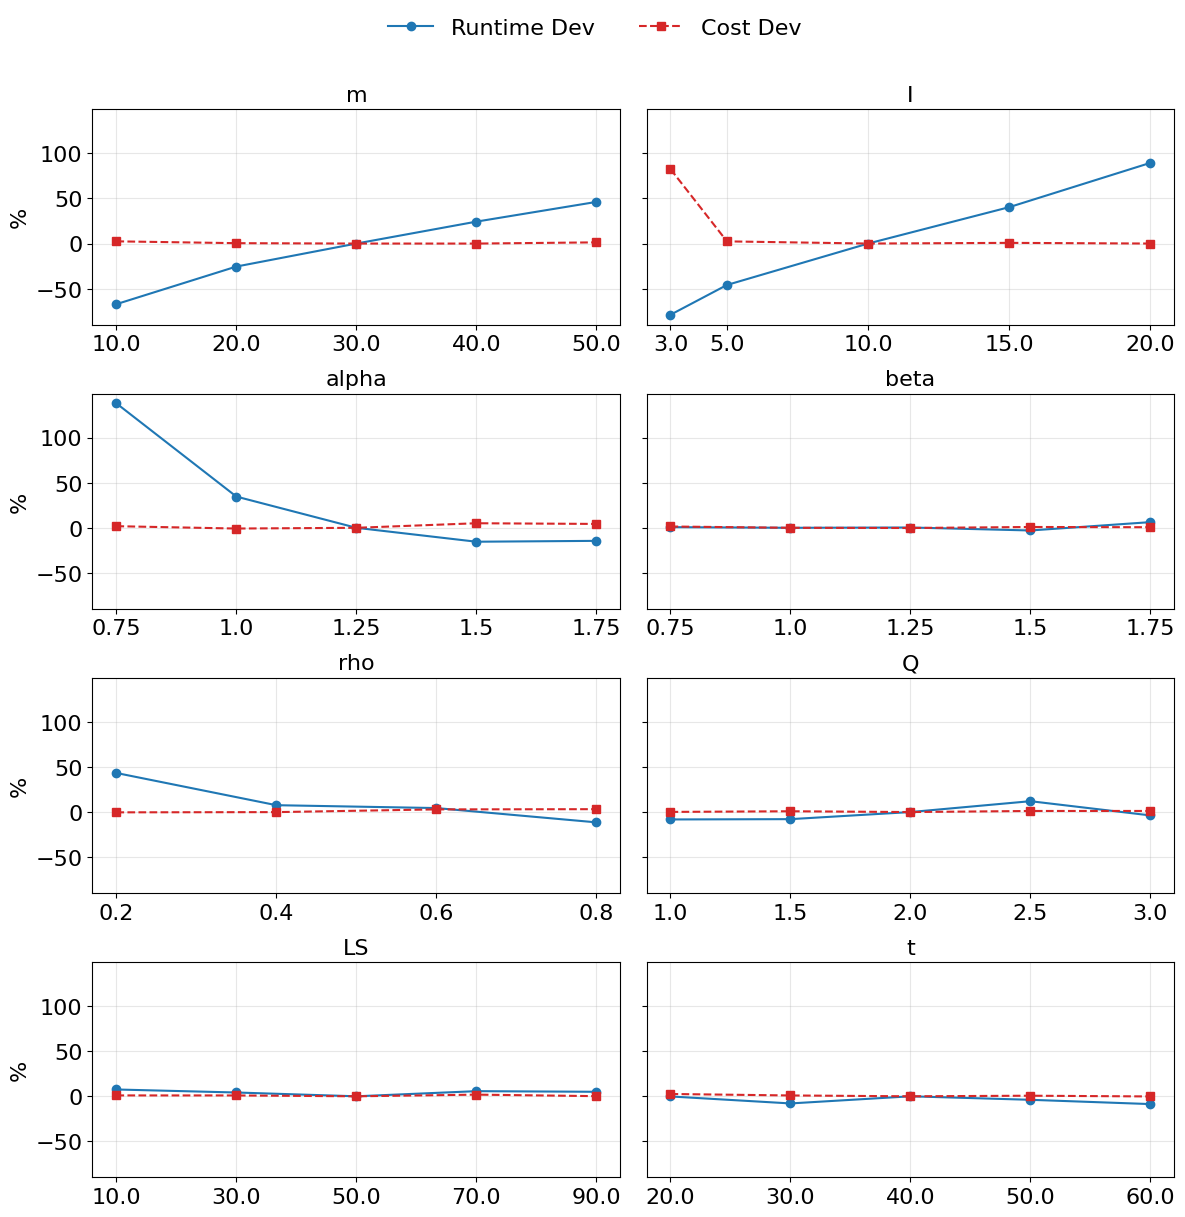

In [9]:
sen_plot(sen_medium)